In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12.0, 7.0)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

from typing import *

from math import ceil

import sys, os
sys.path[0] = os.path.normpath(os.path.join(os.getcwd(), "../"))

from core.utils.utils_query import *
from utils.utils_save import *
from utils.utils_plot import *
from utils.utils import *

from glob import glob
import shutil

In [2]:
import psutil
psutil.cpu_count()
# reset affinity against all eligible CPUs
p = psutil.Process()
p.cpu_affinity([8,9])

In [3]:
RESULTS_ROOT = '../results/'

In [5]:
def get_res(*opt, dims, acq_opt=None):
    res = []    
    if acq_opt is None:
        acq_opt = lambda exp: True
    for d in dims:
        exps = []
        for o in opt:
            exps.extend(query_exps(f'{RESULTS_ROOT}/test_best', [{'q': 16, 'optimizer': o, 'covar':'matern-5/2', 'input_dim': d, 'ub_offset': 0, 'lb_offset': 0}, acq_opt]))
        assert len(exps) == 20, (len(exps), opt, d)
        for exp in exps:
            tf = query_test_func(exp.test_func, exp.input_dim, negate=True)
            best = tf.optimal_value
            best_vals = load_np(exp.result_dir, 'best_values')[:5].mean(0)
            res.append(np.abs(best_vals - best) / np.abs(best_vals[0] - best))
    return res

In [7]:

cmap = plt.get_cmap('tab20')

non_compositional_optimizers = {'LBFSGB',
                                'Adadelta', 
                                'Adagrad', 
                                'Adam', 
                                'Adamos', 
                                'AdamW', 
                                'Rprop', 
                                'RMSprop', 
                                'SGD'}


order_0_optimizers_non_comp = {'CMAESopt', 'DEopt'}
order_0_optimizers_comp = {'CMAESopt-nested', 'DEopt-nested'}
order_0_optimizers = set().union(
    order_0_optimizers_comp,
    order_0_optimizers_non_comp
)

order_1_optimizers_non_comp = {
    'Adadelta', 
    'Adagrad', 
    'Adam', 
    'Adamos', 
    'AdamW', 
    'Rprop', 
    'RMSprop', 
    'SGD'
}
order_1_optimizers_comp = {
    'Adam-nested',
    'CAdam-compo',
    'NASA-compo',
    'Adam-nested-ME',
    'CAdam-compo-ME',
    'NASA-compo-ME',
    'ASCGD-compo',
    'SCGD-compo',
}
order_1_optimizers = set().union(
    order_1_optimizers_comp,
    order_1_optimizers_non_comp
)

order_2_optimizers_non_comp = {'LBFSGB'}
order_2_optimizers_comp = {'LBFSGB-nested'}
order_2_optimizers = set().union(
    order_2_optimizers_comp,
    order_2_optimizers_non_comp
)

compositional_optimizers = set().union(
    order_0_optimizers_comp, 
    order_1_optimizers_comp,
    order_2_optimizers_comp
)

non_compositional_optimizers = set().union(
    order_0_optimizers_non_comp,
    order_1_optimizers_non_comp,
    order_2_optimizers_non_comp
)

cmap_opt = {'RandomSearch': 'gold'}
linestyle_opt = {'RandomSearch': '-'}

linestyles = ['-', ':', '-', '--', '-', '--']
opt_categories = [order_0_optimizers_non_comp, order_0_optimizers_comp, order_1_optimizers_non_comp, order_1_optimizers_comp, order_2_optimizers_non_comp, order_2_optimizers_comp]

for linestyle, category in zip(linestyles, opt_categories):
    for opt in category:
        linestyle_opt[opt] = linestyle
linestyle_opt['FSM'] = '-.'

aux_opt = set(['Adam', 'RMSprop', 'Adagrad', 'Rprop'])
not_free = set()
for i, opt in enumerate(sorted(aux_opt)):
    cmap_opt[opt] = cmap(2 * i)
    not_free.add(2 * i)

next_avaliable = 1
for i, opt in enumerate(sorted(non_compositional_optimizers)):
    if opt in aux_opt:
        continue 
    cmap_opt[opt] = cmap(next_avaliable % cmap.N)
    not_free.add(next_avaliable)
    next_avaliable = (next_avaliable + 1) % cmap.N
    while next_avaliable in not_free:
        next_avaliable = (next_avaliable + 1) % cmap.N
    
aux_opt = set(['CAdam-compo', 'NASA-compo', 'Adam-nested'])
not_free = set()
for i, opt in enumerate(sorted(aux_opt)):
    cmap_opt[opt] = cmap(2 * i)
    not_free.add(2 * i)

next_avaliable = 8
for i, opt in enumerate(sorted(compositional_optimizers)):
    if opt in aux_opt:
        continue 
    cmap_opt[opt] = cmap(next_avaliable % cmap.N)
    not_free.add(next_avaliable)
    next_avaliable = (next_avaliable + 1) % cmap.N
    while next_avaliable in not_free:
        next_avaliable = (next_avaliable + 2) % cmap.N
    

eq_class = {
}


for v in eq_class.values():
    for opt in v:
        cmap_opt[opt] = cmap_opt[v[0]]
        linestyle_opt[opt] = linestyle_opt[v[0]]

cmap_opt['BOHB'] = 'lime'
linestyle_opt['BOHB'] = '-.'
cmap_opt['TS'] = 'red'
linestyle_opt['TS'] = '-.'

def opt_legend(optimizer_name: str) -> str:
    if optimizer_name == 'NASA-compo':
        return 'NASA-old'
    elif optimizer_name == 'NASA-compo-ME':
        return 'NASA-ME'
    elif optimizer_name == 'CAdam-compo':
        return 'CAdam-old'
    elif optimizer_name == 'CAdam-compo-v3':
        return 'CAdam'
    elif optimizer_name == 'CAdam-compo-ME':
        return 'CAdam-ME'
    elif optimizer_name == 'NASA-compo':
        return 'NASA'
    elif optimizer_name in ['ASCGD-compo', 'ASCGD-compo']:
        return 'ASCGD'
    elif optimizer_name == 'ASCGD':
        return 'ASCGD'
    elif optimizer_name in ['SCGD-compo', 'SCGD-compo']:
        return 'SCGD'
    elif optimizer_name == 'SCGD':
        return 'SCGD'
    elif 'CMAESopt' in optimizer_name:
        return 'CMA-ES'
    elif 'DEopt' in optimizer_name:
        return 'DE'
    elif optimizer_name == 'LBFSGB':
        return 'L-BFGS-B'
    elif optimizer_name == 'LBFSGB-nested':
        return 'CL-BFGS-B'
    elif optimizer_name == 'Adam-nested':
        return 'Nested-MC'
    elif optimizer_name == 'Adam-nested-ME':
        return 'Nested-MC-ME'
    else:
        return optimizer_name

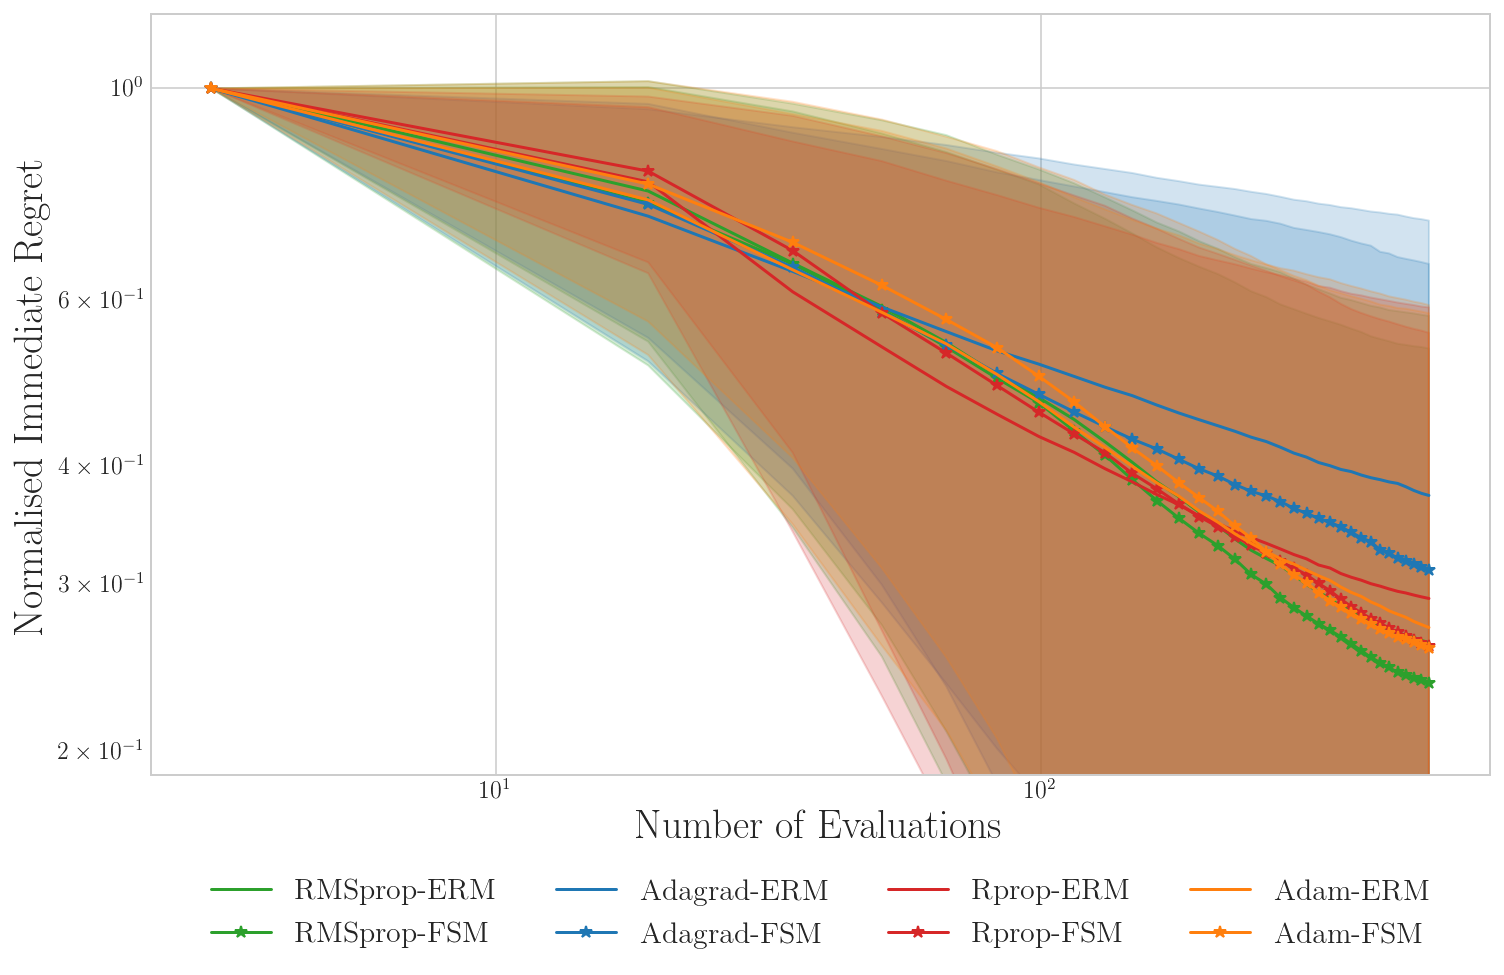

In [7]:
dims = np.array([16, 40, 60, 80, 100, 120])

fig, ax = plt.subplots()

for opt in ['RMSprop', 'Adagrad', 'Rprop', 'Adam']:
    plot_mean_std(np.arange(3, 516, 16), 
                  np.array(get_res(opt, dims=dims, 
                                   acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                           label=f'{opt}-ERM', color=cmap_opt[opt], ax=ax, alpha=.2)

    plot_mean_std(np.arange(3, 516, 16), 
                  np.array(get_res(opt, dims=dims,
                                   acq_opt=lambda exp: exp.acq_func[:5] in ['qFini'])),
                           label=f'{opt}-FSM', color= ax.lines[-1].get_c(), ax=ax, marker='*',  alpha=.2)


y = np.inf
for line in ax.lines:
    yy = line.get_data()[1][-1]
    if yy < y:
        y = yy

ax.set_ylim(.8 *y, 1.2 )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of Evaluations', fontsize=20)
ax.set_ylabel('Normalised Immediate Regret',fontsize=20)
lgd = ax.legend(bbox_to_anchor=[.5, -0.1], loc='upper center', fancybox=True, shadow=True, ncol=4, fontsize=15)
fig.tight_layout(rect=(0., .0, 1, .1))
# plt.title('Expected Risk Maximisation (ERM) v. Finite Sum Maximisation (FSM)', fontsize=20)
fig.savefig('../results/images/summary/erm-v-fsm.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

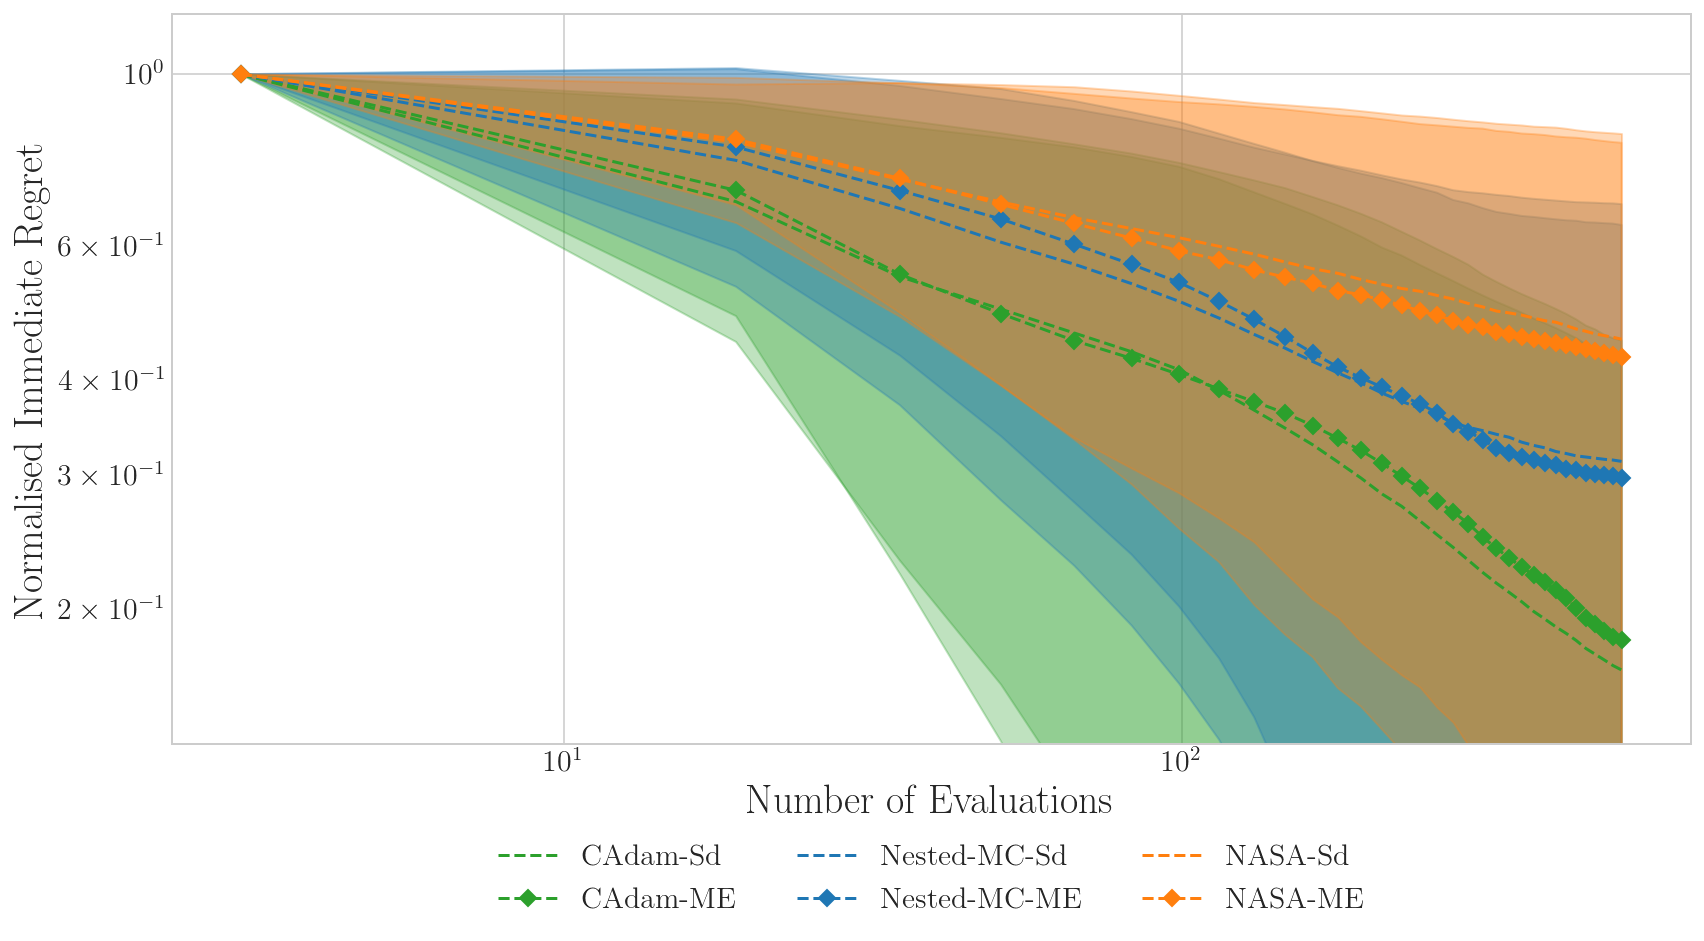

In [23]:
dims = np.array([80, 100, 120])

fig, ax = plt.subplots()

for opt in [('CAdam-compo-v3', 'CAdam-compo-ME'), ('Adam-nested', 'Adam-nested-ME'), ('NASA-compo', 'NASA-compo-ME')]:
    o1, ome = opt
        
    plot_mean_std(np.arange(3, 516, 16), 
                  np.array(get_res(o1, dims=dims, 
                                   acq_opt=lambda exp: exp.acq_func[:5] in ['qComp'])),
                           label=f'{opt_legend(o1)}-Sd', ax=ax, linestyle='--', color=cmap_opt[o1])

    plot_mean_std(np.arange(3, 516, 16), 
                  np.array(get_res(ome, dims=dims, 
                                   acq_opt=lambda exp: exp.acq_func[:5] in ['qComp'])),
                           label=f'{opt_legend(ome)}', color=ax.lines[-1].get_c(), ax=ax, marker='D', linestyle='--')


y = np.inf
for line in ax.lines:
    yy = line.get_data()[1][-1]
    if yy < y:
        y = yy

ax.set_ylim(.8 *y, 1.2 )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of Evaluations', fontsize=20)
ax.set_ylabel('Normalised Immediate Regret',fontsize=20)
lgd = ax.legend(bbox_to_anchor=[.5, -0.1], loc='upper center', fancybox=True, shadow=True, ncol=3, fontsize=15)
fig.tight_layout(rect=(0., .02, 1, .98))
# plt.title('Standard (Sd) v. Memory efficient (ME)', fontsize=20)
plt.savefig('../results/images/summary/sd-v-me.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

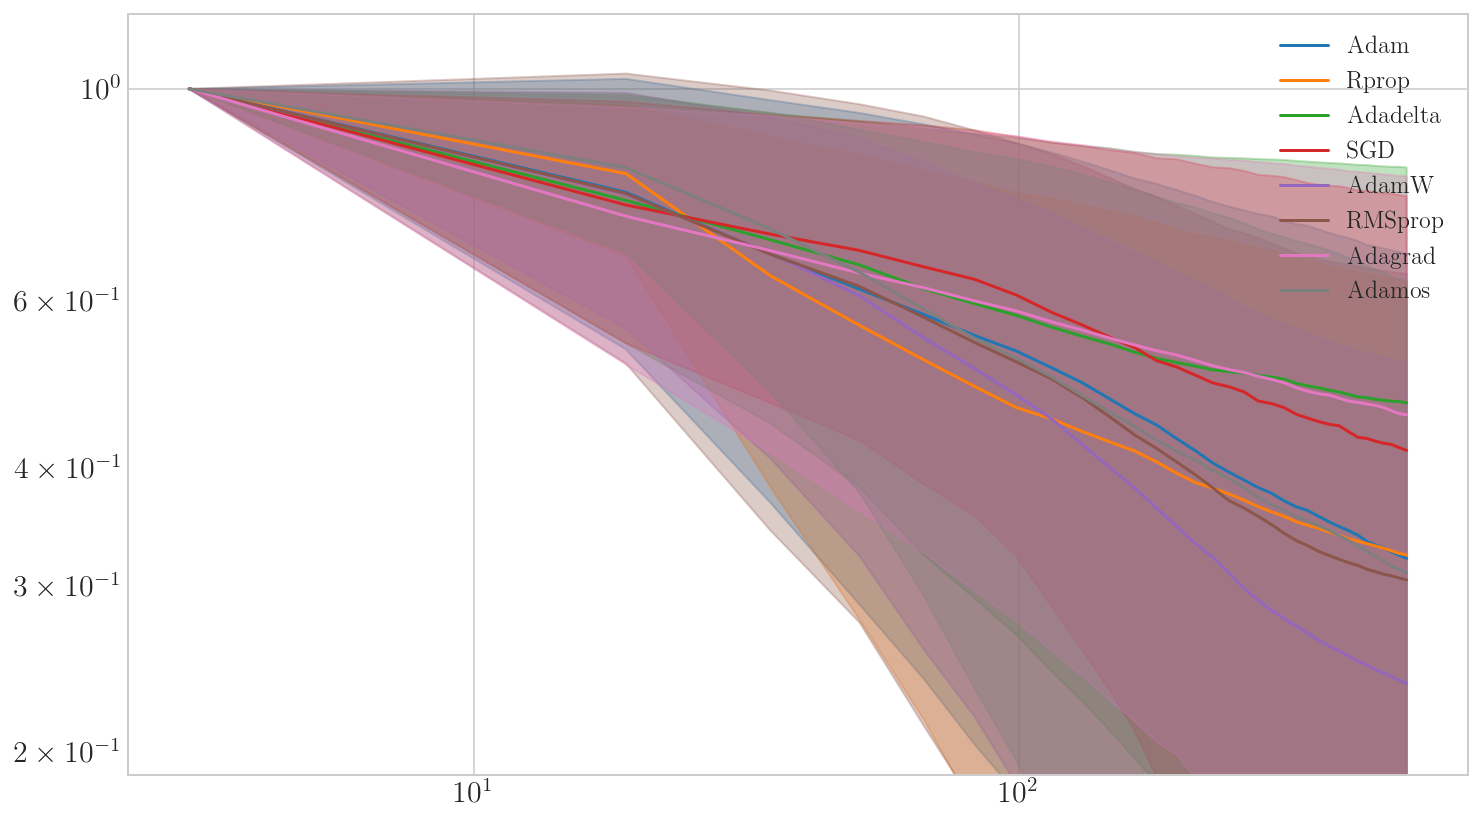

In [24]:
ds = np.array([16])

ax = plt.subplot()

opt = 'Adam'
plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('Adam', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='Adam', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('Rprop', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='Rprop', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('Adadelta', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='Adadelta', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('SGD', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='SGD', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('AdamW', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='AdamW', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('RMSprop', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='RMSprop', ax=ax)

plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('Adagrad', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='Adagrad', ax=ax)


plot_mean_std(np.arange(3, 516, 16), 
              np.array(get_res('Adamos', dims=dims, 
                               acq_opt=lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini'])),
                       label='Adamos', ax=ax)

y = np.inf
for line in ax.lines:
    yy = line.get_data()[1][-1]
    if yy < y:
        y = yy

ax.set_ylim(.8 *y, 1.2 )

ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()

In [114]:
for exp in query_exps('../results/test_best', [{'q': 16, 'optimizer': 'Adam', 'covar':'matern-5/2', 'input_dim': 40, 'ub_offset': 0, 'lb_offset': 0}, lambda exp: exp.acq_func[:5] not in ['qComp', 'qFini']]):
    print(os.path.basename(exp.result_dir))

StyblinskiTang-40-Adam-qSimpleRegret-16-20200905-235045
StyblinskiTang-40-Adam-qExpectedImprovement-16-20200816-200605
StyblinskiTang-40-Adam-qUpperConfidenceBound-16-20200814-053507
StyblinskiTang-40-Adam-qProbabilityOfImprovement-16-20200904-161214
Levy-40-Adam-qSimpleRegret-16-20200901-140900
Levy-40-Adam-qExpectedImprovement-16-20200831-191431
Levy-40-Adam-qFixedUpperConfidenceBound-16-20200827-014601
Levy-40-Adam-qUpperConfidenceBound-16-20200831-011603
Levy-40-Adam-qProbabilityOfImprovement-16-20200901-051527
Ackley-40-Adam-qSimpleRegret-16-20200907-212909
Ackley-40-Adam-qExpectedImprovement-16-20200817-092121
Ackley-40-Adam-qUpperConfidenceBound-16-20200814-094312
Ackley-40-Adam-qProbabilityOfImprovement-16-20200907-062651
DixonPrice-40-Adam-qSimpleRegret-16-20200909-081927
DixonPrice-40-Adam-qExpectedImprovement-16-20200908-110136
DixonPrice-40-Adam-qUpperConfidenceBound-16-20200815-122335
DixonPrice-40-Adam-qProbabilityOfImprovement-16-20200908-220353
Powell-40-Adam-qSimpleReg

In [68]:
ds = [80, 100, 120]
plot_mean_std(np.array(get_res('CAdam-compo-ME', ds)))
plot_mean_std(np.array(get_res('CAdam-compo-v3', ds)))
plot_mean_std(np.array(get_res('NASA-compo', ds)))
plot_mean_std(np.array(get_res('NASA-compo-ME', ds)))
plt.yscale('log')
plt.xscale('log')

TypeError: get_res() missing 1 required keyword-only argument: 'dims'

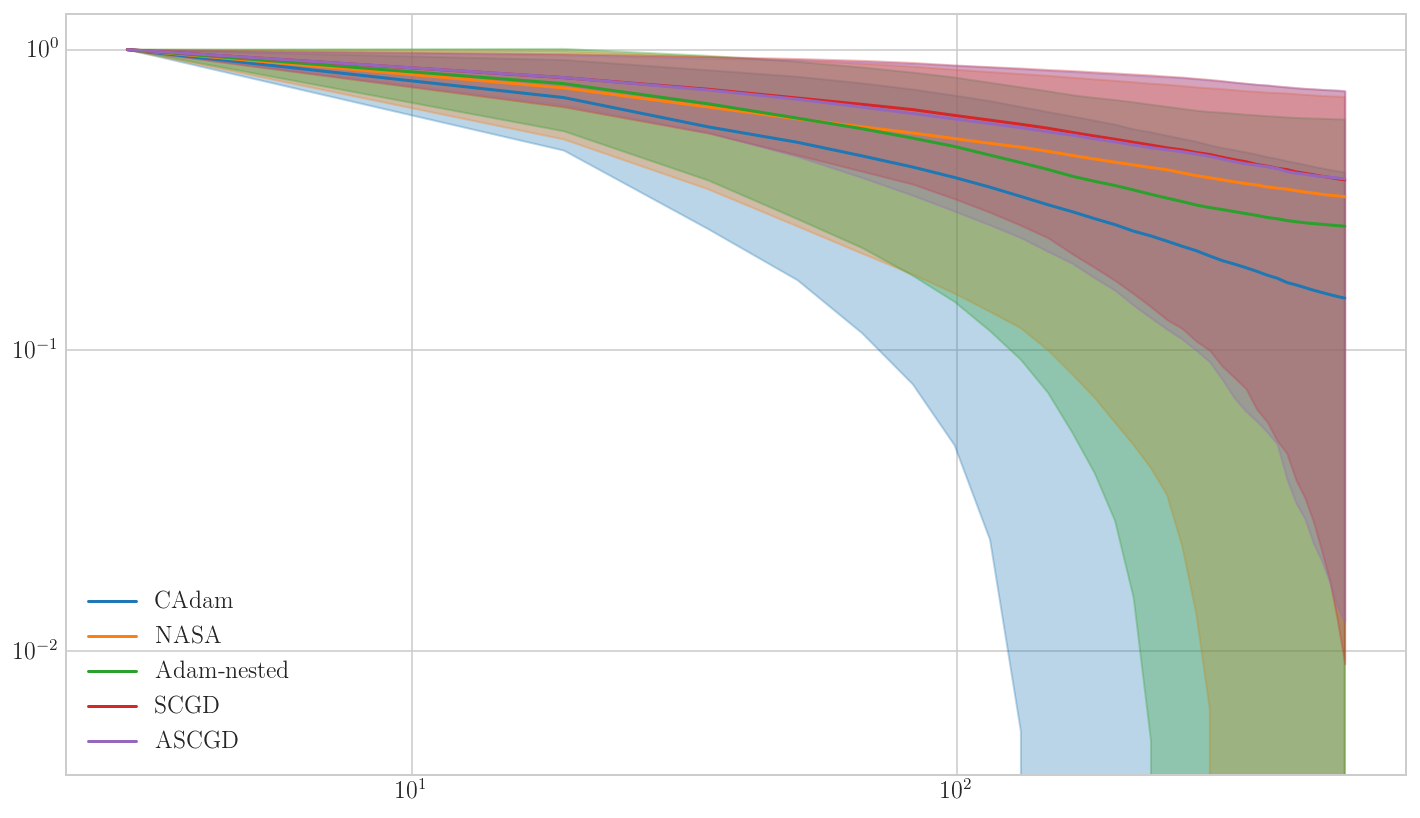

In [93]:
ds = np.array([16, 40, 60, 80, 100, 120])
plot_mean_std(np.arange(3, 516, 16), np.array(get_res('CAdam-compo', dims=ds)), label='CAdam', )
plot_mean_std(np.arange(3, 516, 16), np.array(get_res('NASA-compo',  dims=ds)), label='NASA')

plot_mean_std(np.arange(3, 516, 16), np.array(get_res('Adam-nested',  dims=ds)), label='Adam-nested')
plot_mean_std(np.arange(3, 516, 16), np.array(get_res('SCGD-compo', 'SCGD-compo',  dims=ds)), label='SCGD')
plot_mean_std(np.arange(3, 516, 16), np.array(get_res('ASCGD-compo', 'ASCGD-compo',  dims=ds)), label='ASCGD')


plt.yscale('log')
plt.xscale('log')
plt.legend()

In [8]:
def aux_t(opt, acq, ds, ax=None, i=2, **plot_kw):
    ts = []
    if ax is None:
        ax = plt.subplot()
    if opt not in eq_class:
        selected_opts = [opt]
    else:
        selected_opts = eq_class[opt]
    for d in ds:
        exps = query_exps(f'../results/test_time_{i}/', [{'input_dim': d, 'acq_func': acq}, lambda conf: conf.optimizer in selected_opts])
        if len(exps) == 0:
            print(opt, acq, d, 'no exp')
            continue
#             raise ValueError('No exp')
        res = []
        tf = set()
        for exp in exps:
            if exp.test_func in tf:
                continue
            times = load_np(exp.result_dir, 'execution_times')
            assert times.shape[0] == 5
            res.append(times)
            tf.add(exp.test_func)
        t = np.vstack(res)
        if len(t) != 10:
            print(opt, acq, d, 'not 10')
            continue
        ts.append(t.sum(-1))
    
    if len(ts) == len(ds):
        plot_mean_std(np.array(ds), np.array(ts).T, ax=ax, **plot_kw)
    return ax

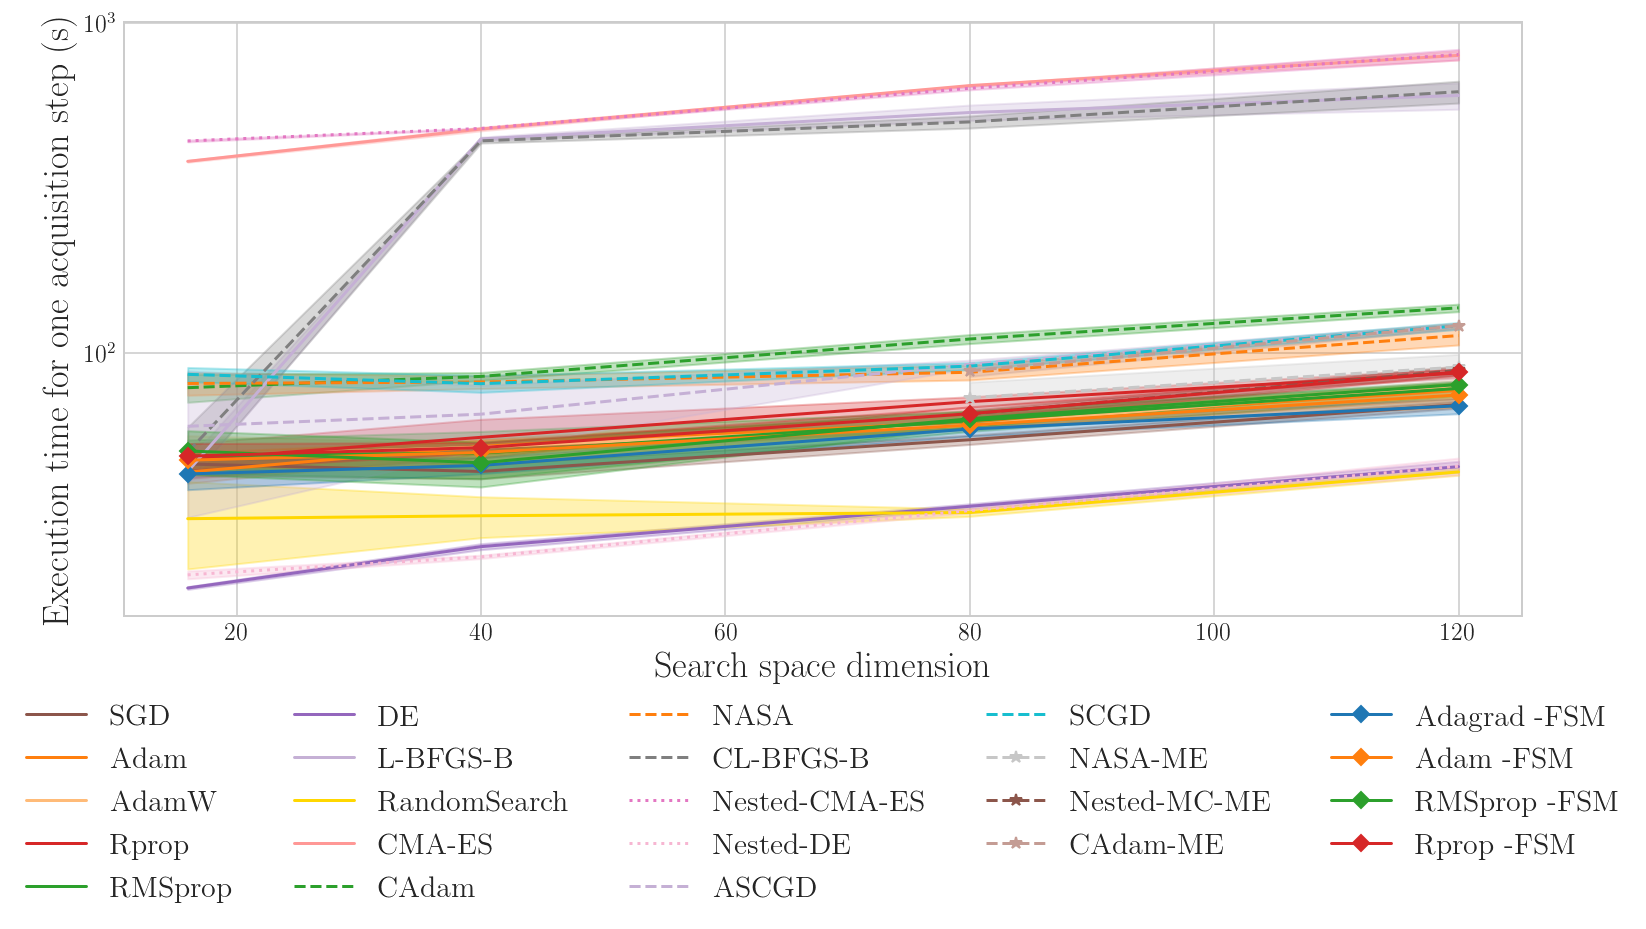

In [10]:
excluded = {'CMAESopt', 'CMAESopt-nested', 'LBFSGB', 'LBFSGB-nested'}
excluded = {}

log = len(excluded) == 0
fig, ax = plt.subplots()
acq_func = 'qUpperConfidenceBound'
for opt in ['SGD', 'Adam', 'AdamW', 'Rprop', 'RMSprop', 'DEopt', 'LBFSGB', 'RandomSearch', 'CMAESopt']:
    if opt in excluded:
        continue
    aux_t(opt, acq_func, [16, 40, 80, 120], i='4cpu', ax=ax, label=f'{opt_legend(opt)}',  linestyle=linestyle_opt[opt], color=cmap_opt[opt])
    
acq_func = 'qCompositionalUpperConfidenceBound'
    
for opt in ['CAdam-compo', 'NASA-compo', 'LBFSGB-nested']:
    if opt in excluded:
        continue
    aux_t(opt, acq_func, [16, 40, 80, 120], i='4cpu', ax=ax, label=f'{opt_legend(opt)}',  linestyle=linestyle_opt[opt], color=cmap_opt[opt])

for opt in ['CMAESopt-nested', 'DEopt-nested']:
    if opt in excluded:
        continue
    aux_t(opt, acq_func, [16, 40, 80, 120], i='4cpu', ax=ax, label=f'Nested-{opt_legend(opt)}',  linestyle=linestyle_opt[opt], color=cmap_opt[opt])
    
for opt in ['ASCGD', 'SCGD']:
    if opt in excluded:
        continue
    if opt in eq_class:
        color = cmap_opt[eq_class[opt][0]]
        linestyle = linestyle_opt[eq_class[opt][0]]
    else:
        color = cmap_opt[opt] 
        linestyle = linestyle_opt[opt]
    aux_t(opt, acq_func, [16, 40, 80, 120], i='4cpu', ax=ax, label=f'{opt_legend(opt)}',  linestyle=linestyle, color=color)

for opt in ['NASA-compo-ME', 'Adam-nested-ME', 'CAdam-compo-ME']:
    if opt in excluded:
        continue
    aux_t(opt, acq_func, [80, 120], i='4cpu', ax=ax, label=f'{opt_legend(opt)}', linestyle=linestyle_opt[opt], color=cmap_opt[opt], marker='*')

acq_func = 'qFiniteSumUpperConfidenceBound'
for opt in ['Adagrad', 'Adam', 'RMSprop', 'Rprop']:
    if opt in excluded:
        continue
    aux_t(opt, acq_func, [16, 40, 80, 120], i='4cpu', ax=ax, label=opt + ' -FSM', linestyle=linestyle_opt[opt], color=cmap_opt[opt], marker = 'D')


ax.set_xlabel('Search space dimension', fontsize=18)
ax.set_ylabel('Execution time for one acquisition step (s)', fontsize=18)
if log:
    ax.set_yscale('log')

lgd = ax.legend(bbox_to_anchor=[.5, -0.1], loc='upper center', fancybox=True, shadow=True, ncol=5, fontsize=15)
fig.tight_layout(rect=(0., .02, 1, .98))
# plt.title('Standard (Sd) v. Memory efficient (ME)', fontsize=20)
extension = 'selection' if len(excluded) > 0 else ''

if log:
    extension += '-log'
fig.savefig(f'../results/images/summary/time-{extension}.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

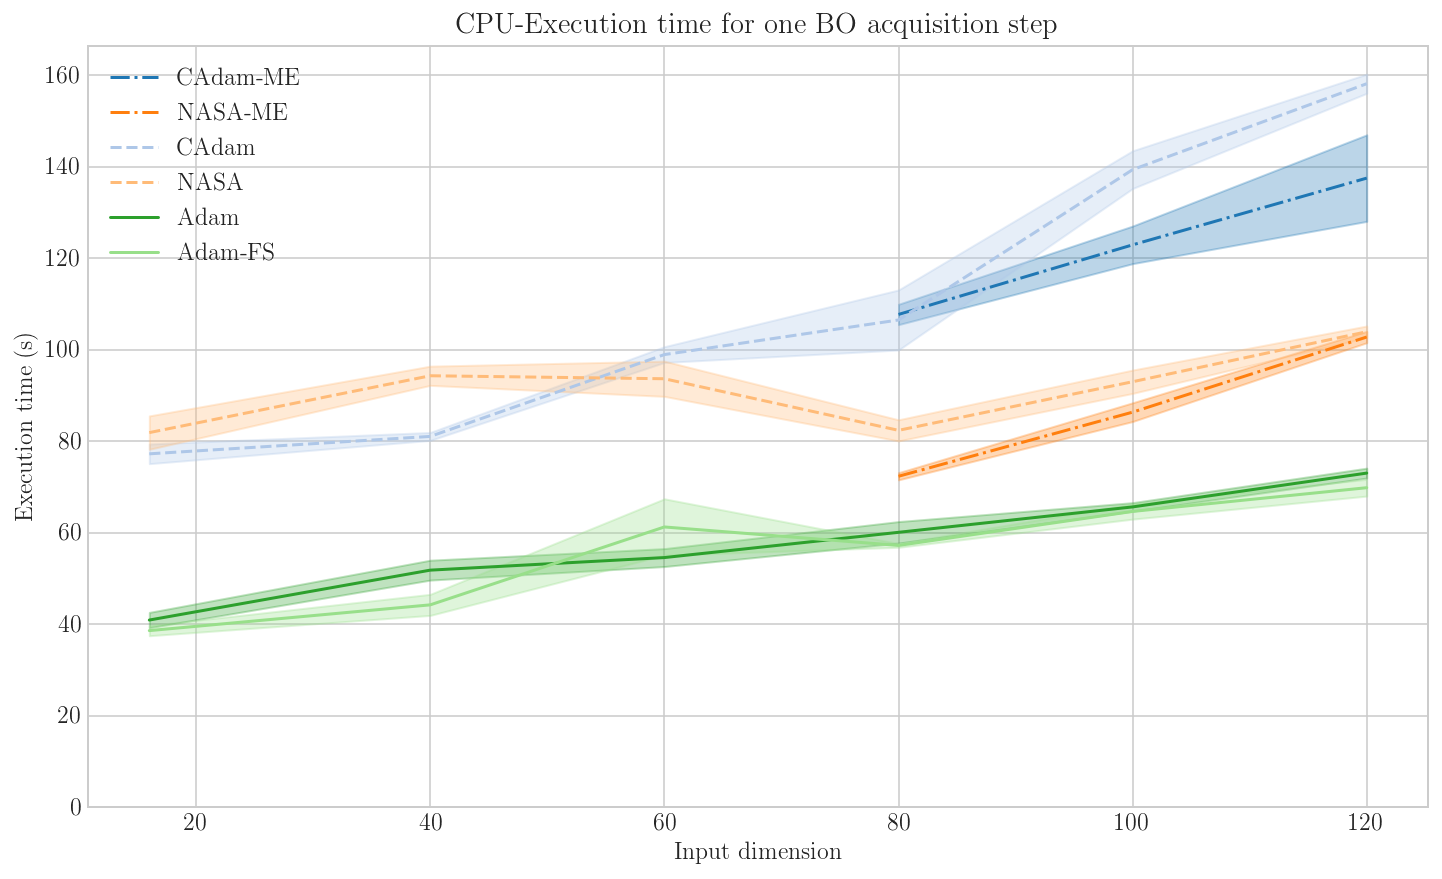

In [10]:


ds = [80, 100, 120]
opt = 'CAdam-compo-ME'
acq_func = 'qCompositionalUpperConfidenceBound'
ax = aux_t(opt, acq_func, ds, label='CAdam-ME', linestyle='-.', color=cmap(0))

opt = 'NASA-compo-ME'
ax = aux_t(opt, acq_func, ds, label='NASA-ME', linestyle='-.', color=cmap(2))

ds = [16, 40, 60, 80, 100, 120]
opt = 'CAdam-compo'
ax = aux_t(opt, acq_func, ds, label='CAdam', linestyle='--', color=cmap(1) )

opt = 'NASA-compo'
ax = aux_t(opt, acq_func, ds, label='NASA', linestyle='--', color=cmap(3) )

# opt = 'CMAESopt'
# ax = aux_t(opt, acq_func.replace('Compositional', ''), ds, label='CMAESopt', linestyle='--' )


opt = 'Adam'
ax = aux_t(opt, acq_func.replace('Compositional', ''), ds, label='Adam' , color=cmap(4))

opt = 'Adam'
ax = aux_t(opt, acq_func.replace('Compositional', 'FiniteSum'), ds, label='Adam-FSM' ,color=cmap(5))

ax.legend()
ax.set_xlabel('Input dimension')
ax.set_ylabel('Execution time (s)')
# ax.set_title('CPU-Execution time for one BO acquisition step')
ax.set_ylim(0, ax.get_ylim()[-1])
plt.savefig('../results/images/summary/time.pdf')

In [4]:
cmap = plt.get_cmap('tab20')

non_compositional_optimizers = {'LBFSGB',
                                'Adadelta', 
                                'Adagrad', 
                                'Adam', 
                                'Adamos', 
                                'AdamW', 
                                'Rprop', 
                                'RMSprop', 
                                'SGD'}


order_0_optimizers_non_comp = {'CMAESopt', 'DEopt'}
order_0_optimizers_comp = {'CMAESopt-nested', 'DEopt-nested'}
order_0_optimizers = set().union(
    order_0_optimizers_comp,
    order_0_optimizers_non_comp
)

order_1_optimizers_non_comp = {
    'Adadelta', 
    'Adagrad', 
    'Adam', 
    'Adamos', 
    'AdamW', 
    'Rprop', 
    'RMSprop', 
    'SGD'
}
order_1_optimizers_comp = {
    'Adam-nested',
    'NASA-compo',
    'Adam-nested-ME',
    'CAdam-compo-ME',
    'NASA-compo-ME',
    'CAdam-compo',
    'NASA-compo',
    'SCGD-compo',
    'ASCGD-compo',
    'SCGD-compo',
    'SCGD-compo',
    'ASCGD-compo',
    'SCGD-compo',
}
order_1_optimizers = set().union(
    order_1_optimizers_comp,
    order_1_optimizers_non_comp
)

order_2_optimizers_non_comp = {'LBFSGB'}
order_2_optimizers_comp = {'LBFSGB-nested'}
order_2_optimizers = set().union(
    order_2_optimizers_comp,
    order_2_optimizers_non_comp
)

compositional_optimizers = set().union(
    order_0_optimizers_comp, 
    order_1_optimizers_comp,
    order_2_optimizers_comp
)

non_compositional_optimizers = set().union(
    order_0_optimizers_non_comp,
    order_1_optimizers_non_comp,
    order_2_optimizers_non_comp
)

cmap_opt = {0: {'RandomSearch': cmap(12), 'Comp': cmap(0), 'Non-Comp': cmap(1)},
            1: {'Comp': cmap(2), 'Non-Comp': cmap(3)},
            2: {'Comp': cmap(10), 'Non-Comp': cmap(11)},
            'BOHB': 'lime',
            'TS': cmap(14),
            'FSM': cmap(18)
           }
linestyle_opt = {0: {'RandomSearch': ':', 'Comp': '--', 'Non-Comp': '-'},
                 1: {'Comp': '--', 'Non-Comp': '-'},
                 2: {'Comp': '--', 'Non-Comp': '-'},
                 'BOHB': 'dashdot',
                 'TS': '-.',
                 'FSM': '-.'
                }
marker_opt = {0: {'RandomSearch': 'd', 'Comp': '>', 'Non-Comp': '<'}, 
              1: {'Comp': '1', 'Non-Comp': 's'}, 
              2: {'Comp': '+', 'Non-Comp': '*'}, 
              'BOHB': 'x',
              'TS': 'H',
              'FSM': '|'
             }

# for opt in compositional_optimizers:
#     linestyle_opt[opt] = '--'
# for opt in non_compositional_optimizers:
#         linestyle_opt[opt] = '-'
        
# for opt in order_0_optimizers:
#     cmap_opt[opt] = cmap(0 + (opt in order_0_optimizers_comp))

# for opt in order_1_optimizers:
#     cmap_opt[opt] = cmap(2 + (opt in order_1_optimizers_comp))
    
# for opt in order_2_optimizers:
#     cmap_opt[opt] = cmap(4 + (opt in order_2_optimizers_comp))


In [5]:
""" Define the set of optimizers that have been used for the tasks to summerize """ 

selected_optimizers_dic = {
    (16, 'matern-5/2'): set(['LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested', 'RandomSearch', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW', 'Rprop', 'RMSprop', 'SGD', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    (16, 'rbf'): set(['LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested',  'DEopt', 'DEopt-nested','RandomSearch', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW', 'Rprop', 'RMSprop', 'SGD', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    
    (40, 'matern-5/2'): set(['LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested',  'RandomSearch', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    (40, 'rbf'): set(['LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested',  'DEopt', 'DEopt-nested','RandomSearch', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),

    (60, 'matern-5/2'):  set(['LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo' ]),
    (60, 'rbf'):  set(['Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo' ]),

    (80, 'matern-5/2'):  set(['NASA-compo-ME', 'Adam-nested-ME','CAdam-compo-ME', 'LBFSGB','LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    (80, 'rbf'):  set(['Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo-v3',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),

    (100, 'matern-5/2'):  set(['NASA-compo-ME', 'Adam-nested-ME','CAdam-compo-ME', 'LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo-v3',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    (100, 'rbf'):  set(['Adagrad', 'Adam', 'Rprop', 'RMSprop', 'RandomSearch', 'CAdam-compo-v3',  'NASA-compo']),

    (120, 'matern-5/2'):  set(['NASA-compo-ME', 'Adam-nested-ME','CAdam-compo-ME', 'LBFSGB', 'LBFSGB-nested', 'CMAESopt', 'CMAESopt-nested', 'DEopt', 'DEopt-nested', 'Adadelta', 'Adagrad', 'Adam', 'Adam-nested', 'Adamos', 'AdamW',  'Rprop', 'RMSprop', 'SGD', 'RandomSearch', 'CAdam-compo-v3',  'NASA-compo', 'SCGD-compo', 'ASCGD-compo']),
    (120, 'rbf'):  set(['Adagrad', 'Adam', 'Rprop', 'RMSprop', 'RandomSearch', 'CAdam-compo-v3',  'NASA-compo'])

}

In [6]:
""" Elements to iterate over the tasks """
input_dims = [16, 40, 60, 80, 100, 120]
input_dims = [16, 40, 60, 80, 100, 120]

lb_offset, ub_offset = None, None
test_funcs = ['Levy', 'DixonPrice', 'Ackley', 'Powell', 'StyblinskiTang']

num_test_seeds = 5
remove_bad = 3

ts = True
fs = True
bohb = True
""" General info for BO """
num_initial = 3
num_acq_steps = 32
q = 16
covar = 'matern-5/2'

""" Score aggregation """

agg = 'min'  # can be `median`, `mean`, `min` (`min` is for best performance)


In [7]:
""" Elements to iterate over the tasks """
acq_funcs = ['qUpperConfidenceBound', 'qExpectedImprovement', 'qSimpleRegret', 'qProbabilityOfImprovement']


""" 
Summary dict of the form:
{
`order` (0, 1, 2):
    {
    `comp` / `non_comp` / `RandomSearch` (random search) : List of regrets/score data for each task
    }
}

"""

summary = {i: {'Comp': [[]], 'Non-Comp': [[]]} for i in range(3)}   # initilize with a List that will contain the list of scores for all tasks
summary[0]['RandomSearch'] = [[]]  # Random search is 0-order

""" Iterate over tasks """
for input_dim in input_dims:
    optimizers = selected_optimizers_dic[(input_dim, covar)]
    
    for test_func in test_funcs:        
        tf_ref = None
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value

        for acq_func in acq_funcs:
            
            """ Iterate over optimizers used for this task """
            
            for optimizer in optimizers:
                # collect scores
                
                rel_path = exp_folder_rel_path_aux(root_result_dir='test_best', test_func=test_func, input_dim=input_dim, acq_func=acq_func, q=q, optimizer=optimizer, lb_offset=lb_offset, ub_offset=ub_offset)
                
                exp = query_exps(f'{RESULTS_ROOT}/{rel_path}', {'covar':covar}, key= lambda config: config.result_dir[-15:])
                assert len(exp) == 1, (input_dim, acq_func, test_func, optimizer)
                exp = exp[0]
                
                # store scores in the summary dictionary
                im_regret = np.abs(load_np(exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
                tf_ref = im_regret[:, 0]
                im_regret /= tf_ref[:, None]
                
                if optimizer in order_2_optimizers_comp:
                    summary[2]['Comp'][-1].append(im_regret.mean(0))
                elif optimizer in order_2_optimizers_non_comp:
                    summary[2]['Non-Comp'][-1].append(im_regret.mean(0))
                    
                elif optimizer in order_0_optimizers_comp:
                    summary[0]['Comp'][-1].append(im_regret.mean(0))
                elif optimizer in order_0_optimizers_non_comp:
                    summary[0]['Non-Comp'][-1].append(im_regret.mean(0))
                    
                elif optimizer in order_1_optimizers_comp:
                    summary[1]['Comp'][-1].append(im_regret.mean(0))
                elif optimizer in order_1_optimizers_non_comp:
                    summary[1]['Non-Comp'][-1].append(im_regret.mean(0))
                    
                elif optimizer == 'RandomSearch':
                    summary[0]['RandomSearch'][-1].append(im_regret.mean(0))
            
            for i in [1, 2, 0]: # iterate over order
                for v in summary[i].keys(): # iterate over type of optimizers
                    data = summary[i][v]    # collect the list of scores obtained by each optimizer of the given type
                    
                    if len(data[-1]) == 0:
                        continue  # no optimizer has been run for this type for the current task
                    else:
                        data[-1] = np.atleast_2d(data[-1])
                        """ Remove the worse `remove_bad` optimizers of this type """
                        inds = data[-1][:, -1].argsort()
                        n_remove = min(remove_bad, len(data[-1]) - 1)  # leave at least one of the category
                        inds = inds if n_remove == 0 else inds[:-n_remove] 
                        data[-1] = data[-1][inds] 
                        
                        """ Aggregate results for this type """
                        if agg == 'mean':
                            data[-1] = data[-1].mean(0)
                        elif agg == 'min':
                            data[-1] = data[-1][0]
                        elif agg == 'median':
                            data[-1] = np.median(data[-1], axis=0)
                        else:
                            raise ValueError(f'invalid value for `agg`: {agg}')
                        data.append([])   

""" Post processing (just removing last empty list for each type in summary dict) """
for i in [1, 2, 0]:
    for v in summary[i].keys():
        data = summary[i][v]
        if len(data) == 0:
            continue
        else:
            assert data[-1] == []
            data.pop()

In [8]:
summary_ts = []
summary_bohb = []

""" Iterate over tasks """
for input_dim in input_dims:    
    for test_func in test_funcs: 
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value
        
        # deal with BOHB
        if bohb:
            bohb_exp = None
            test_func_str = f'{test_func}_{input_dim}D'
            if lb_offset is not None and lb_offset != 0:
                test_func_str += f'_lb{str(lb_offset)}'
            if ub_offset is not None and ub_offset != 0:
                test_func_str += f'_ub{str(ub_offset)}'
            bohb_exps = query_exps(f'{RESULTS_ROOT}/BOHB/{test_func_str}')
            assert len(bohb_exps) == 1, (len(bohb_exps), test_func_str) 
            bohb_exp = bohb_exps[0]
            im_regret = np.abs(load_np(bohb_exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
            tf_ref = im_regret[:, 0]
            im_regret /= tf_ref[:, None]

            summary_bohb.append(im_regret.mean(0))
        
        if ts and input_dim <= 40 :
            mean_ts, _, _ = query_ts_data(os.path.join(RESULTS_ROOT, 'TS'), test_func=test_func, input_dim=input_dim, typ='dec')
            summary_ts.append(np.exp(mean_ts[::q] - mean_ts[0]))


In [9]:
fs_acq_funcs = ['qFiniteSumUpperConfidenceBound', 'qFiniteSumExpectedImprovement', 'qFiniteSumSimpleRegret', 'qFiniteSumProbabilityOfImprovement']
fs_optimizers = ['RMSprop', 'Rprop', 'Adagrad', 'Adam']

summary_fs = [[]]  # finite-sum

""" Iterate over tasks """
for input_dim in input_dims:    
    for test_func in test_funcs:        
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value
        
        tf_ref = None
        for acq_func in fs_acq_funcs:
            
            """ Iterate over optimizers used for this task """
            
            for optimizer in fs_optimizers:
                # collect scores
                
                rel_path = exp_folder_rel_path_aux(root_result_dir='test_best', test_func=test_func, input_dim=input_dim, acq_func=acq_func, q=q, optimizer=optimizer, lb_offset=lb_offset, ub_offset=ub_offset)
                
                exp = query_exps(f'{RESULTS_ROOT}/{rel_path}', {'covar':covar}, key= lambda config: config.result_dir[-15:])
#                 assert len(exp) == 1, (input_dim, acq_func, test_func, optimizer)
                if len(exp) != 1:
                    print(input_dim, acq_func, test_func, optimizer)
                    continue
                exp = exp[0]
                
                # store scores in the summary dictionary
                im_regret = np.abs(load_np(exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
                tf_ref = im_regret[:, 0]
                im_regret /= tf_ref[:, None]
                
                summary_fs[-1].append(im_regret.mean(0))
                
            data = summary_fs    # collect the list of scores obtained by each optimizer of the given type
                    
            if len(data[-1]) == 0:
                continue  # no optimizer has been run for this type for the current task
            else:
                data[-1] = np.atleast_2d(data[-1])
                """ Remove the worse `remove_bad` optimizers of this type """
                inds = data[-1][:, -1].argsort()
                n_remove = min(remove_bad, len(data[-1]) - 1)  # leave at least one of the category
                inds = inds if n_remove == 0 else inds[:-n_remove] 
                data[-1] = data[-1][inds] 

                """ Aggregate results for this type """
                if agg == 'mean':
                    data[-1] = data[-1].mean(0)
                elif agg == 'min':
                    data[-1] = data[-1][0]
                elif agg == 'median':
                    data[-1] = np.median(data[-1], axis=0)
                else:
                    raise ValueError(f'invalid value for `agg`: {agg}')
                data.append([])   

""" Post processing (just removing last empty list for each type in summary dict) """
assert len(summary_fs[-1]) == 0
summary_fs.pop();

BOHB 0.6149610452171415
TS 0.7759520117312654
1-FSM 0.1652583389356256
1 Comp (120, 33)
1-Compositional 0.09464161930870613
1 Non-Comp (120, 33)
1-Non-Compositional 0.1623019758011676
2 Comp (120, 33)
2-Compositional 0.35393960983205264
2 Non-Comp (120, 33)
2-Non-Compositional 0.3822088533486229
0 Comp (120, 33)
0-Compositional 0.5653372085043222
0 Non-Comp (120, 33)
0-Non-Compositional 0.5643897875594142
0 RandomSearch (120, 33)
RS 0.5921446800296349


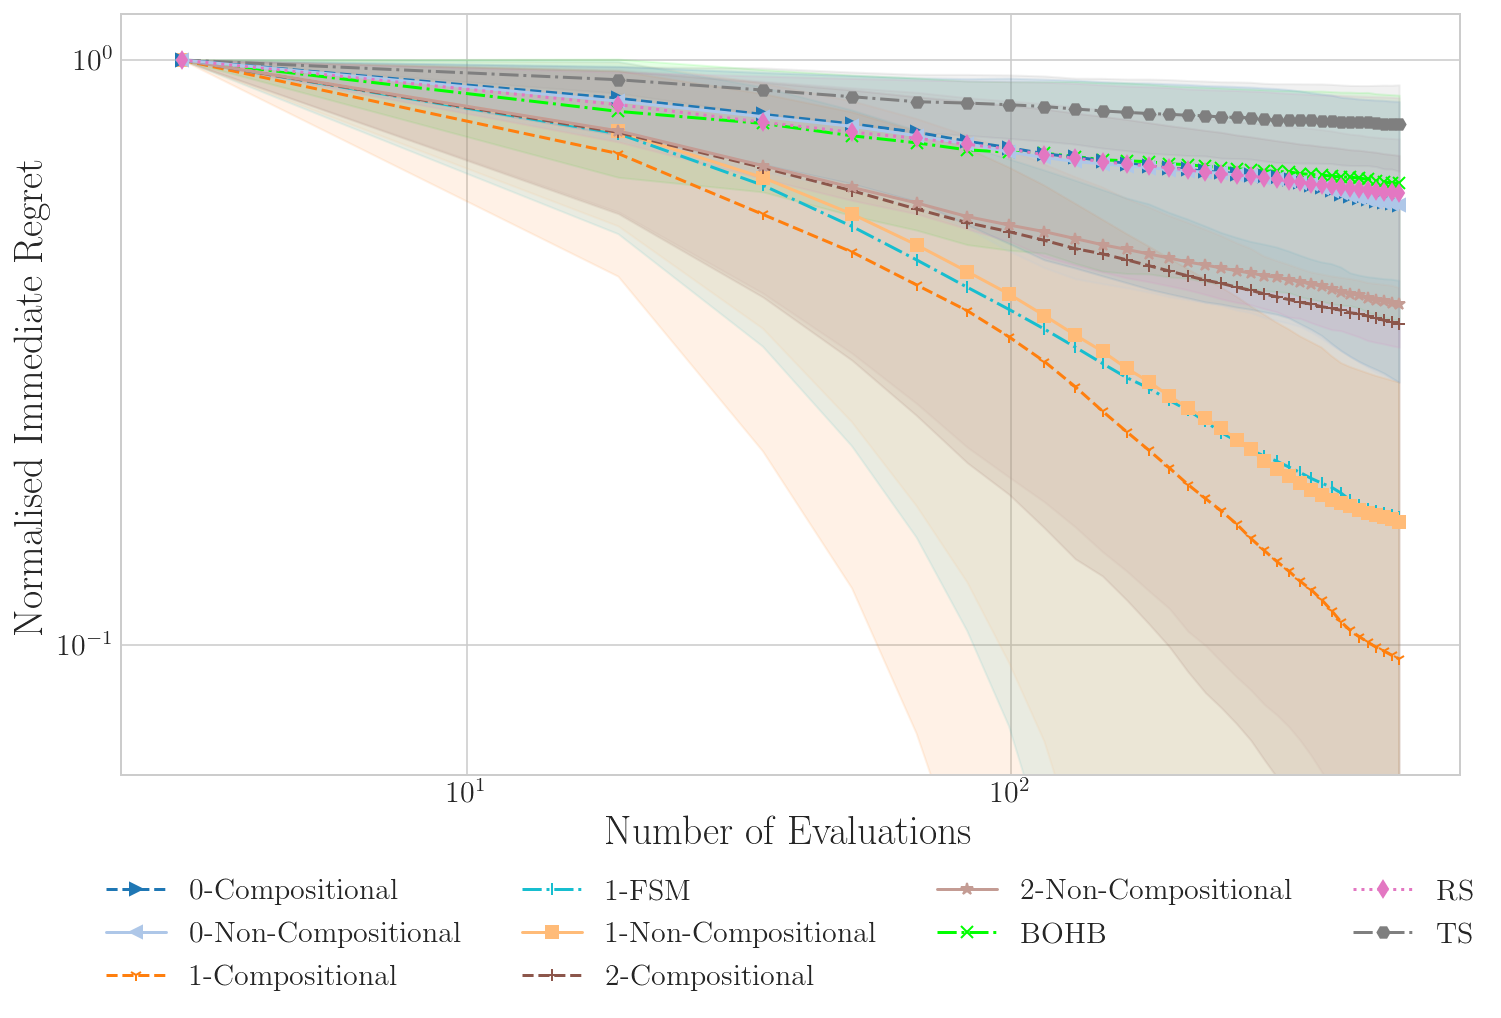

In [10]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

fig, ax = plt.subplots()
X = np.arange(num_initial, num_acq_steps * q +q, q)

for summ, name, add_res in zip([summary_bohb, summary_ts, summary_fs], ['BOHB', 'TS', 'FSM'], [bohb, ts, fs]):
    if add_res:
        data = np.array(summ)
        linestyle = linestyle_opt[name]
        color = cmap_opt[name]
        marker = marker_opt[name]
        label = name
        if name == 'FSM':
            label = '1-FSM'
        plot_mean_std(X, data, label=label, n_std=1, alpha=.1, color=color, ax=ax, linestyle=linestyle, marker=marker)
        print(label, data.mean(0)[-1])

for i in [1, 2, 0]:
    
    for v in summary[i].keys():
        linestyle = linestyle_opt[i][v]
        color = cmap_opt[i][v]
        marker = marker_opt[i][v]
        
        label = f'{i}-{v}ositional' if v != 'RandomSearch' else 'RS'
        data = summary[i][v]
        if len(data) == 0:
            print(f'No data for {label}')
            continue
            
        data = np.array(data)
        print(i, v, data.shape)
        
        plot_mean_std(X, data, label=label, n_std=1, alpha=.1, color=color, ax=ax, linestyle=linestyle, marker=marker)
        print(label, data.mean(0)[-1])

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
lgd = ax.legend(handles, labels, bbox_to_anchor=[.5, -0.1], loc='upper center', fancybox=True, shadow=True, ncol=4, fontsize=15)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((.06, 1.2))
ax.set_xlabel('Number of Evaluations',  fontsize=20)
ax.set_ylabel('Normalised Immediate Regret',  fontsize=20)

if agg == 'mean':
    title_kw = 'Average'
elif agg == 'min':
    title_kw = 'Best'
elif agg == 'median':
    title_kw = 'Median'
title = f'{title_kw} performance on Synthetic tasks'
# ax.set_title(title, fontsize=20)

extension = '-no-ts-bohb'
filename = f"summary-{title.replace(' ', '-')}-{covar.replace('/','')}-{remove_bad}" #  + extension
save_dir = f"{RESULTS_ROOT}/images/summary/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(f'{save_dir}/{filename}.pdf', bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.tight_layout(rect=(0., .0, 1, .1))
plt.show()

In [26]:
def plot_summary_ax(acq_func, input_dim, covar='matern-5/2', agg='min', ax=None, bohb=False, ts=False, fs=True):
    if ax is None:
        ax = plt.subplot()

    summary = {0: {'RandomSearch': [[]], 'Comp': [[]], 'Non-Comp': [[]]}}  # Random search is 0-order
    for i in range(1, 3):
        summary[i] = {'Comp': [[]], 'Non-Comp': [[]]}   # initilize with a List that will contain the list of scores for all tasks

    """ Iterate over tasks """
    optimizers = selected_optimizers_dic[(input_dim, covar)]

    for test_func in test_funcs:        
        tf_ref = None
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value

        """ Iterate over optimizers used for this task """

        for optimizer in optimizers:
            # collect scores

            rel_path = exp_folder_rel_path_aux(root_result_dir='test_best', test_func=test_func, input_dim=input_dim, acq_func=acq_func, q=q, optimizer=optimizer, lb_offset=lb_offset, ub_offset=ub_offset)

            exp = query_exps(f'{RESULTS_ROOT}/{rel_path}', {'covar':covar}, key= lambda config: config.result_dir[-15:])
            assert len(exp) == 1, (input_dim, acq_func, test_func, optimizer)
            exp = exp[0]

            # store scores in the summary dictionary
            im_regret = np.abs(load_np(exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
            tf_ref = im_regret[:, 0]
            im_regret /= tf_ref[:, None]

            if optimizer in order_2_optimizers_comp:
                summary[2]['Comp'][-1].append(im_regret.mean(0))
            elif optimizer in order_2_optimizers_non_comp:
                summary[2]['Non-Comp'][-1].append(im_regret.mean(0))

            elif optimizer in order_0_optimizers_comp:
                summary[0]['Comp'][-1].append(im_regret.mean(0))
            elif optimizer in order_0_optimizers_non_comp:
                summary[0]['Non-Comp'][-1].append(im_regret.mean(0))

            elif optimizer in order_1_optimizers_comp:
                summary[1]['Comp'][-1].append(im_regret.mean(0))
            elif optimizer in order_1_optimizers_non_comp:
                summary[1]['Non-Comp'][-1].append(im_regret.mean(0))

            elif optimizer == 'RandomSearch':
                summary[0]['RandomSearch'][-1].append(im_regret.mean(0))

        for i in [1, 2, 0]: # iterate over order
            for v in summary[i].keys(): # iterate over type of optimizers
                data = summary[i][v]    # collect the list of scores obtained by each optimizer of the given type

                if len(data[-1]) == 0:
                    continue  # no optimizer has been run for this type for the current task
                else:
                    data[-1] = np.atleast_2d(data[-1])
                    """ Remove the worse `remove_bad` optimizers of this type """
                    inds = data[-1][:, -1].argsort()
                    n_remove = min(remove_bad, len(data[-1]) - 1)  # leave at least one of the category
                    inds = inds if n_remove == 0 else inds[:-n_remove] 
                    data[-1] = data[-1][inds] 

                    """ Aggregate results for this type """
                    if agg == 'mean':
                        data[-1] = data[-1].mean(0)
                    elif agg == 'min':
                        data[-1] = data[-1][0]
                    elif agg == 'median':
                        data[-1] = np.median(data[-1], axis=0)
                    else:
                        raise ValueError(f'invalid value for `agg`: {agg}')
                    data.append([])   

    """ Post processing (just removing last empty list for each type in summary dict) """
    for i in [0, 1, 2]:
        for v in summary[i].keys():
            data = summary[i][v]
            if len(data) == 0:
                continue
            else:
                assert data[-1] == []
                data.pop()
                
    summary_fs = [[]]  # finite-sum
    
    acq_func = f"qFiniteSum{acq_func[1:]}"
    """ Iterate over tasks """
    for test_func in test_funcs:        
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value

        tf_ref = None

        """ Iterate over optimizers used for this task """

        for optimizer in fs_optimizers:
            # collect scores

            rel_path = exp_folder_rel_path_aux(root_result_dir='test_best', test_func=test_func, input_dim=input_dim, acq_func=acq_func, q=q, optimizer=optimizer, lb_offset=lb_offset, ub_offset=ub_offset)

            exp = query_exps(f'{RESULTS_ROOT}/{rel_path}', {'covar':covar}, key= lambda config: config.result_dir[-15:])
#                 assert len(exp) == 1, (input_dim, acq_func, test_func, optimizer)
            if len(exp) != 1:
                print(input_dim, acq_func, test_func, optimizer)
                continue
            exp = exp[0]

            # store scores in the summary dictionary
            im_regret = np.abs(load_np(exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
            tf_ref = im_regret[:, 0]
            im_regret /= tf_ref[:, None]

            summary_fs[-1].append(im_regret.mean(0))

        data = summary_fs    # collect the list of scores obtained by each optimizer of the given type

        if len(data[-1]) == 0:
            continue  # no optimizer has been run for this type for the current task
        else:
            data[-1] = np.atleast_2d(data[-1])
            """ Remove the worse `remove_bad` optimizers of this type """
            inds = data[-1][:, -1].argsort()
            n_remove = min(remove_bad, len(data[-1]) - 1)  # leave at least one of the category
            inds = inds if n_remove == 0 else inds[:-n_remove] 
            data[-1] = data[-1][inds] 

            """ Aggregate results for this type """
            if agg == 'mean':
                data[-1] = data[-1].mean(0)
            elif agg == 'min':
                data[-1] = data[-1][0]
            elif agg == 'median':
                data[-1] = np.median(data[-1], axis=0)
            else:
                raise ValueError(f'invalid value for `agg`: {agg}')
            data.append([])   

    """ Post processing (just removing last empty list for each type in summary dict) """
    assert len(summary_fs[-1]) == 0
    summary_fs.pop();
    
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 

    X = np.arange(num_initial, num_acq_steps * q +q, q)
    
    summary_ts = []
    summary_bohb = []

    """ Iterate over tasks """
    for test_func in test_funcs: 
        tf = query_test_func(test_func, input_dim, negate=1)
        tf_optimal = tf.optimal_value

        # deal with BOHB
        if bohb:
            bohb_exp = None
            test_func_str = f'{test_func}_{input_dim}D'
            if lb_offset is not None and lb_offset != 0:
                test_func_str += f'_lb{str(lb_offset)}'
            if ub_offset is not None and ub_offset != 0:
                test_func_str += f'_ub{str(ub_offset)}'
            bohb_exps = query_exps(f'{RESULTS_ROOT}/BOHB/{test_func_str}')
            assert len(bohb_exps) == 1, (len(bohb_exps), test_func_str) 
            bohb_exp = bohb_exps[0]
            im_regret = np.abs(load_np(bohb_exp.result_dir, 'best_values')[:num_test_seeds] - tf_optimal)
            tf_ref = im_regret[:, 0]
            im_regret /= tf_ref[:, None]

            summary_bohb.append(im_regret.mean(0))

        if ts and input_dim <= 40 :
            mean_ts, _, _ = query_ts_data(os.path.join(RESULTS_ROOT, 'TS'), test_func=test_func, input_dim=input_dim, typ='dec')
            summary_ts.append(np.exp(mean_ts[::q] - mean_ts[0]))
    
    
    mini_y = np.inf
    maxi_y = -np.inf
    
    best = ''
            
    for i in [0, 2, 1]:
        
        for v in summary[i].keys():
            linestyle = linestyle_opt[i][v]
            color = cmap_opt[i][v]
            marker = marker_opt[i][v]

            label = f'{i}-{v}ositional' if v != 'RandomSearch' else 'RS'
            data = summary[i][v]
            if len(data) == 0:
                print(f'No data for {label}')
                continue

            data = np.array(data)

            plot_mean_std(X, data, label=label, n_std=1, alpha=.1, color=color, ax=ax, linestyle=linestyle, marker=marker)

            if data[...,0].mean() > maxi_y:
                maxi_y = data[...,0].mean()
            if data[...,-1].mean() < mini_y:
                mini_y = data[...,-1].mean()
                best = label
                
    for summ, name, add_res in zip([summary_fs, summary_bohb, summary_ts], ['FSM', 'BOHB', 'TS'], [fs, bohb, ts and input_dim <= 40]):
        if add_res:
            data = np.array(summ)
            linestyle = linestyle_opt[name]
            color = cmap_opt[name]
            marker = marker_opt[name]
            label = name
            if name == 'FSM':
                label = '1-FSM'
            
            plot_mean_std(X, data, label=label, n_std=1, alpha=.1, color=color, ax=ax, linestyle=linestyle, marker=marker)
            
            if data[...,0].mean() > maxi_y:
                maxi_y = data[...,0].mean()
            if data[...,-1].mean() < mini_y:
                mini_y = data[...,-1].mean()
                best = label
                
#         ax.legend( fontsize=15)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim((mini_y / 1.2,  maxi_y * 1.2))
#         ax.set_xlabel('Number of Evaluations',  fontsize=20)
#         ax.set_ylabel('Normalised Immediate Regret',  fontsize=20)

#         if agg == 'mean':
#             title_kw = 'Average'
#         elif agg == 'min':
#             title_kw = 'Best'
#         elif agg == 'median':
#             title_kw = 'Median'
#         title = f'{title_kw} performance'
#         ax.set_title(title, fontsize=20)

#         filename = f"summary-{title.replace(' ', '-')}-{covar.replace('/','')}-{remove_bad}-no-ts-bohb"
#         save_dir = f"{RESULTS_ROOT}/images/summary/"
#         if not os.path.exists(save_dir):
#             os.makedirs(save_dir)
#         plt.savefig(f'{save_dir}/{filename}.pdf', bbox_inches='tight')

#         plt.show()
    
    return ax, best

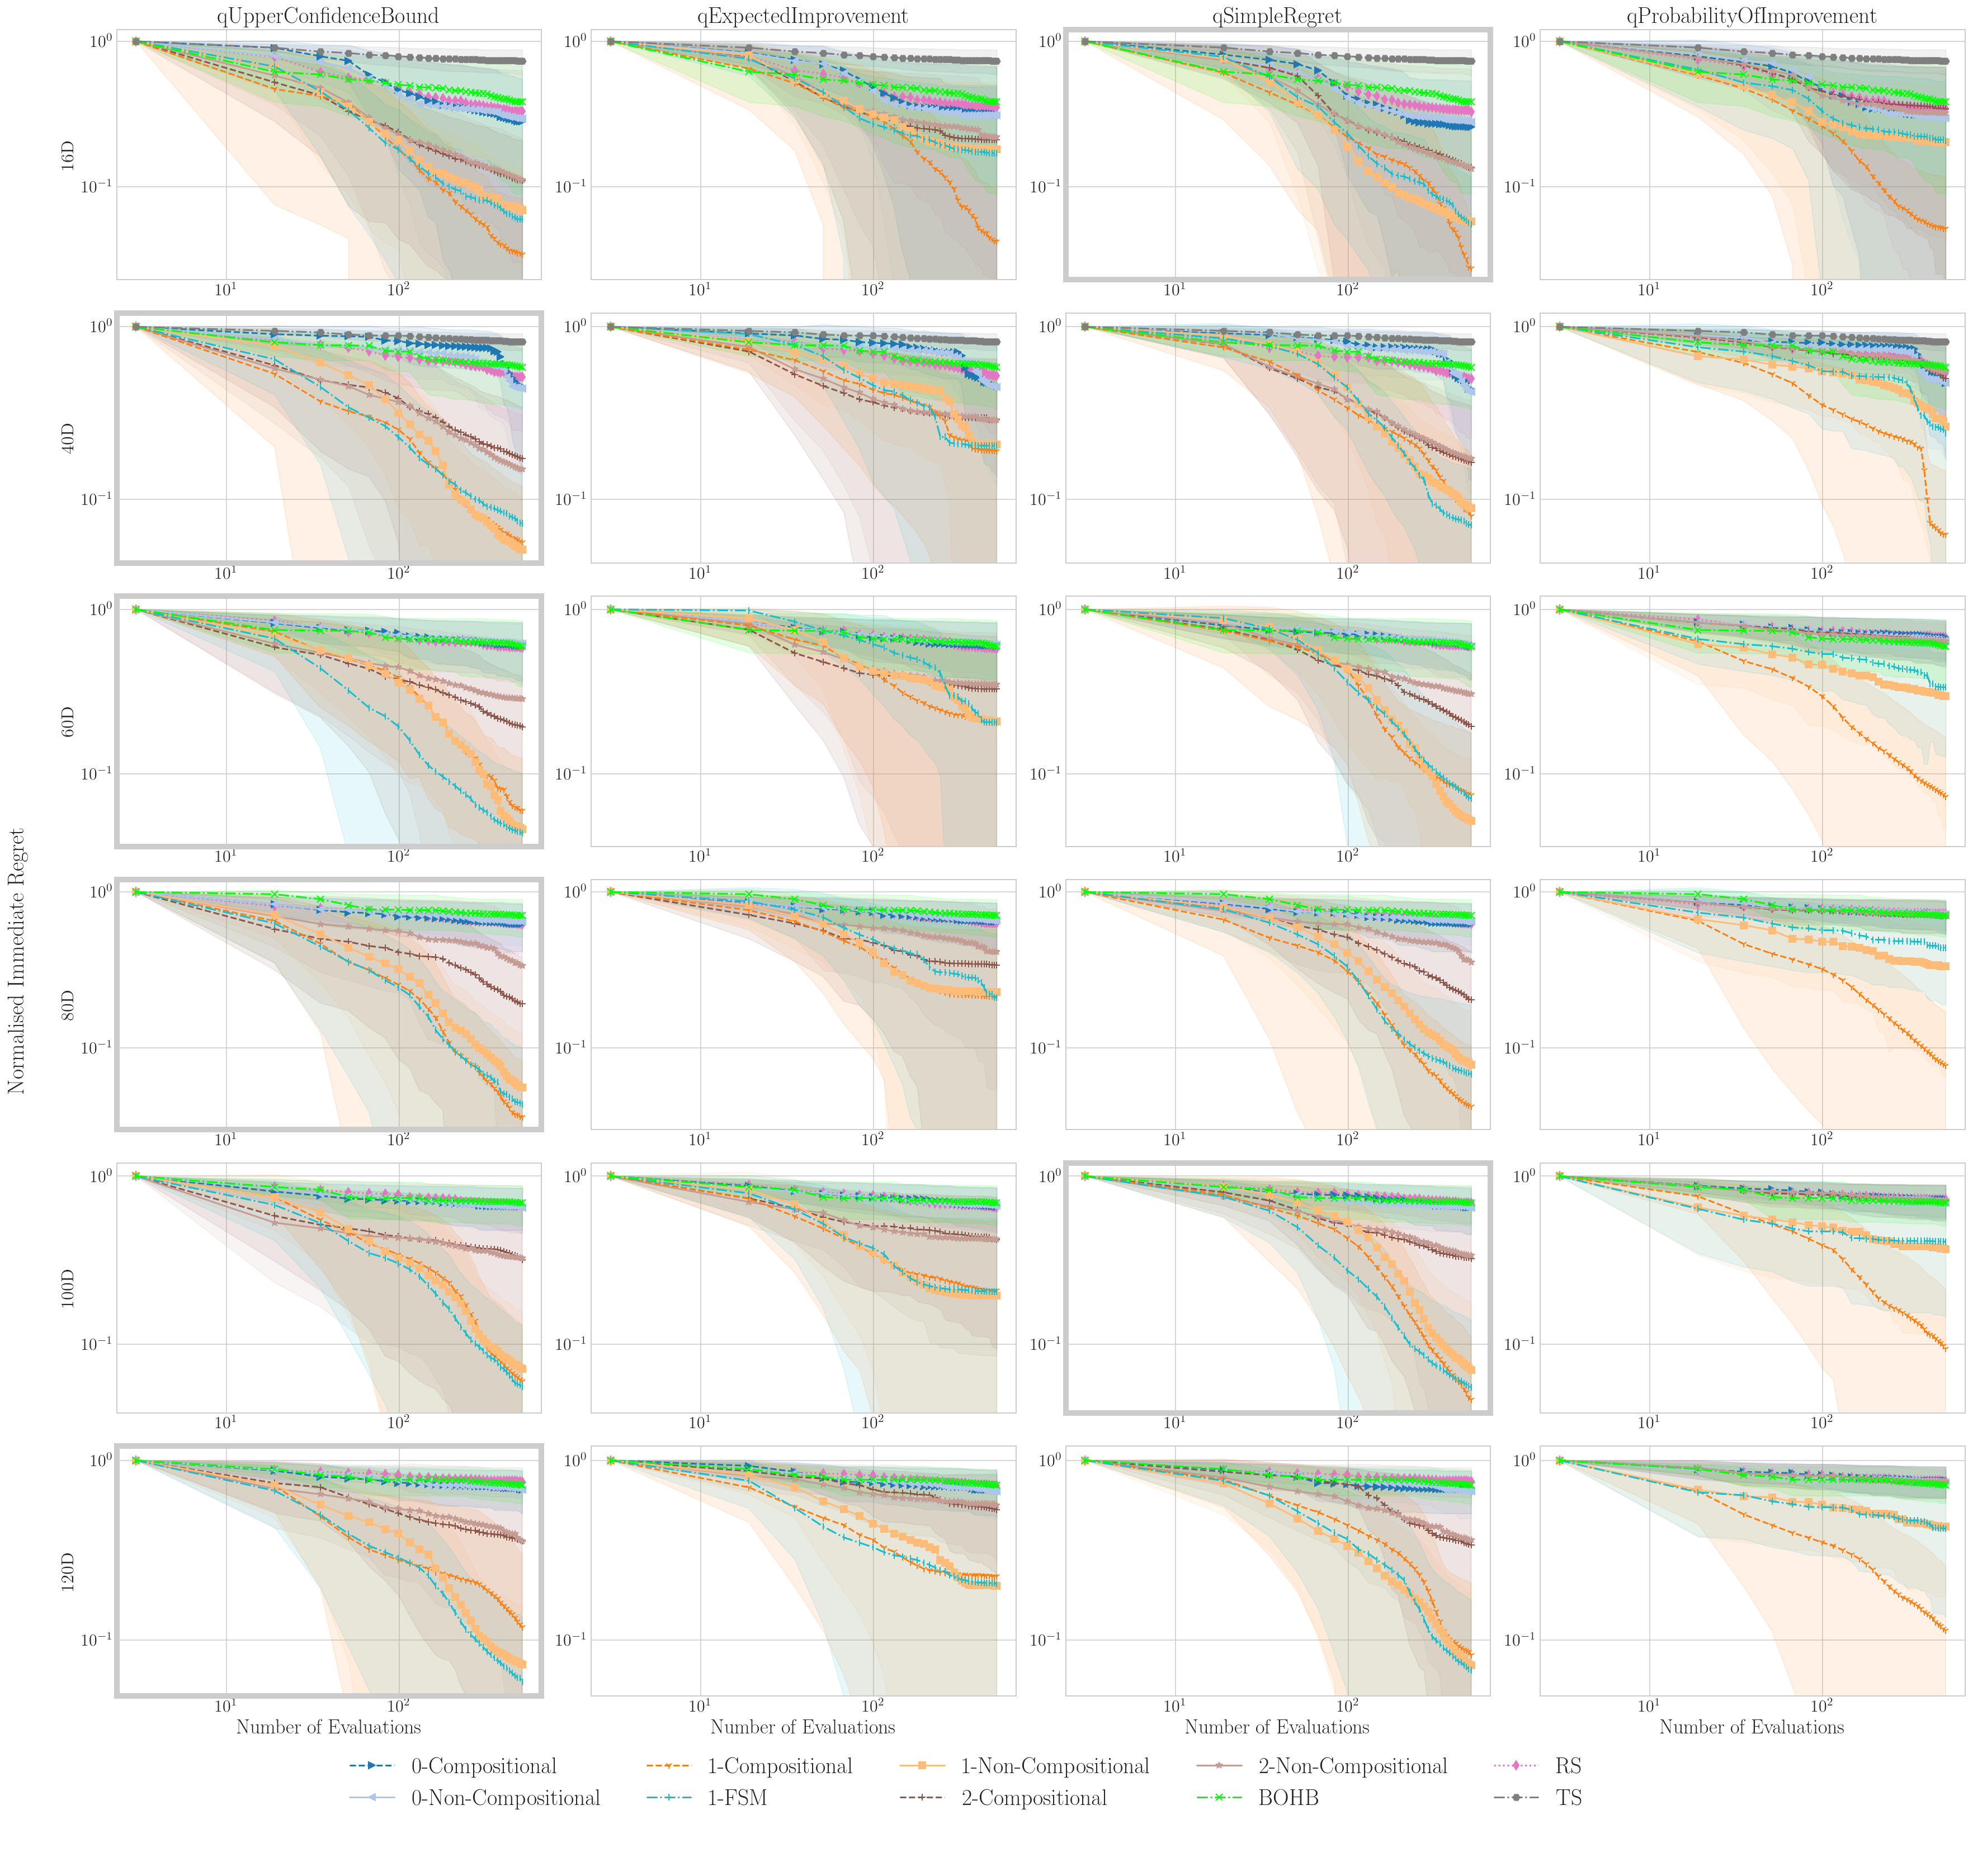

In [27]:
dims = [16, 40, 60, 80, 100, 120]
n_cols = len(acq_funcs)
n_rows = len(dims)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), sharey=False)
axes = axes.reshape(n_rows, n_cols)

for i_d, input_dim in enumerate(dims):
    yM = -np.inf
    ym = np.inf
    i = 0
    best_i = ''
    for i_a, acq_func in enumerate(acq_funcs):
        ax = axes[i_d, i_a]
        if i_a == 0:
            ax.set_ylabel(f'{input_dim}D',  fontsize=16)
        if i_d == 0:
            ax.set_title(f'{acq_func}', fontsize=20)
        if i_d == n_rows - 1:
            ax.set_xlabel('Number of Evaluations',  fontsize=18)
        try:
            ax, best = plot_summary_ax(acq_func, input_dim, ax=ax, bohb=True, ts=True)
        except Exception as e:
            print(input_dim, acq_func)
            raise(e)
        y_mini, y_maxi = ax.get_ylim()
        if ym > y_mini:
            ym = y_mini
            i = i_a
            best_i = best
        if y_maxi > yM:
            yM = y_maxi
    for k, ax in enumerate(axes[i_d]):
        ax.set_ylim(ym, yM)
        if k ==i:
#             ax.scatter([2], [ym * 1.2], marker='*', s=300, c='r')
#             ax.text(2.5, ym * 1.15, best_i)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(5)
#             ax.spines['bottom'].set_color('grey')
#             ax.spines['top'].set_color('grey') 
#             ax.spines['right'].set_color('grey')
#             ax.spines['left'].set_color('grey')
            
#             ax.tick_params(axis='x', colors='grey')
#             ax.tick_params(axis='y', colors='grey')
            
fig.text(-0.02, 0.5, 'Normalised Immediate Regret', va='center', rotation='vertical', fontsize=20)

# fig.text(0.3, 1.02, 'Best performance on Synthetic tasks for varying acquisition function and input space dimensions', fontsize=25)

handles, labels = axes[0,0].get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
 
n_col_legend = ceil(len(labels) / 2)
n_bbox = (len(labels) - 1) // n_col_legend + 1
y_bbox = 0.044 + n_bbox * 0.014

lgd = fig.legend(handles, labels, bbox_to_anchor=[.5, y_bbox], loc='upper center', fancybox=True, shadow=True, ncol=n_col_legend, fontsize=20)
fig.tight_layout(rect=(0,.09,1,1))

extension = '-no-ts-bohb'
filename = f"summary-acq_func_input-{covar.replace('/','')}"  #+ extension
save_dir = f"{RESULTS_ROOT}/images/summary/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(f'{save_dir}/{filename}.pdf', bbox_inches='tight')

plt.show()